In [1]:
import LLMSR
import openai
import base64
import io
import copy

import numpy as np
import matplotlib.pyplot as plt
import torch.nn

from kan import *

In [2]:
client = openai.OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key="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",
)
LLMSR.llm.check_key_limit(client)

91.5053112

cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.50e-03 | test_loss: 5.35e-03 | reg: 9.86e+00 | : 100%|█| 500/500 [00:33<00:00, 14.78


saving model version 0.1


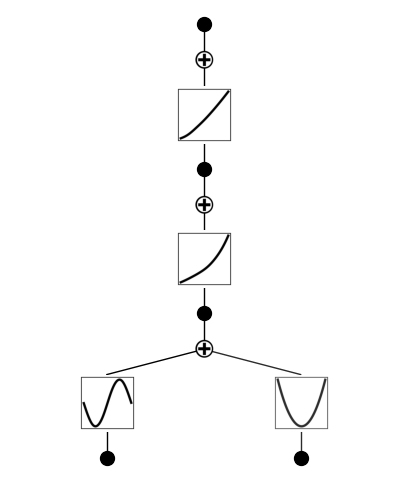

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# initialize KAN with G=3
model = KAN(width=[2,1,1,1], grid=5, k=3, seed=9223, device=device, symbolic_enabled=False)

# create dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, train_num=10000, test_num=1000, device=device)
res = model.fit(dataset, opt="LBFGS", steps=500);
model.plot()

# fit KANs splines

(0, 0, 0)


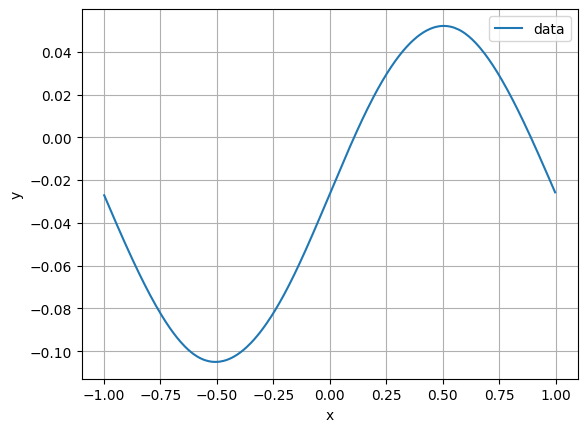

Checking constant function
Constant function is not a good fit.
Score:  -4.114860642367882
Constant:  [-0.02731661]
Generating Initial population population


100%|██████████| 10/10 [00:35<00:00,  3.55s/it]


Best score:  -14.117160381430768
Best ansatz:  params[0] * x
Best params:  [0.07571259]
Generation: 1


100%|██████████| 10/10 [00:27<00:00,  2.72s/it]

Best score:  -0.0006577285320432093
Best ansatz:   params[0] * np.sin(params[1] * x + params[2]) + params[3]
Best params:  [-0.07868157  3.14173489 -3.14195857 -0.02651872]
Exit condition met.
(0, 1, 0)


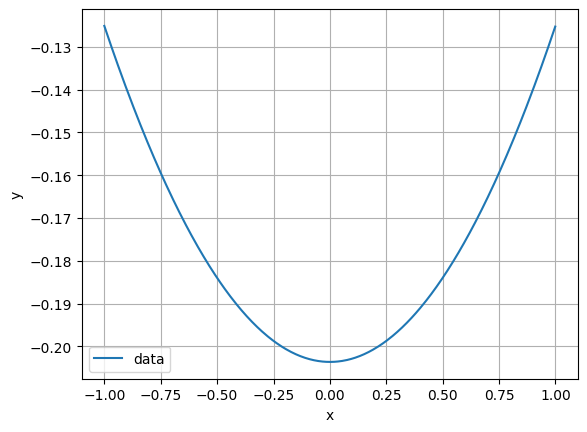

Checking constant function
Constant function is not a good fit.
Score:  -0.017998433569528096
Constant:  [-0.17677789]
Generating Initial population population


100%|██████████| 10/10 [00:49<00:00,  4.97s/it]

Best score:  -1.4932499865122144e-09
Best ansatz:   params[0] + params[1] * x + params[2] * x**2
Best params:  [-2.03640147e-01  7.45449009e-06  7.85642234e-02]
Exit condition met.
(1, 0, 0)


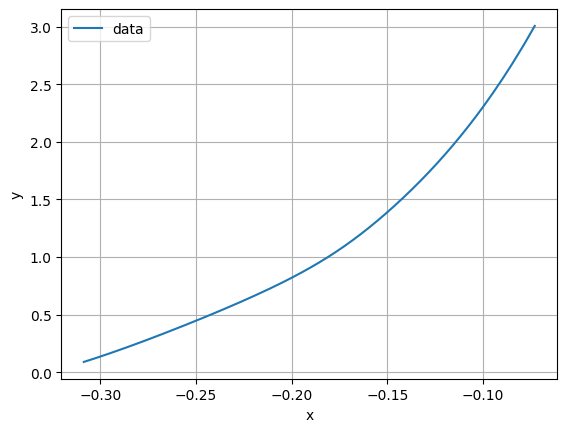

Checking constant function
Constant function is not a good fit.
Score:  -0.45799127648356613
Constant:  [0.91997378]
Generating Initial population population


100%|██████████| 10/10 [00:43<00:00,  4.39s/it]


Best score:  -48.758691726494256
Best ansatz:   params[0] + params[1] * x
Best params:  [ 2.97176488 10.05314255]
Generation: 1


100%|██████████| 10/10 [00:22<00:00,  2.20s/it]


Best score:  -0.011728710314082612
Best ansatz:   params[0] * x**2 + params[1] * x + params[2]
Best params:  [40.61717407 26.52465645  4.49440194]
Generation: 2


100%|██████████| 10/10 [00:39<00:00,  3.91s/it]

Best score:  -0.0007090104996827505
Best ansatz:   params[0] + params[1] * x + params[2] * x**2 + params[3] * x**3
Best params:  [  5.74776852  48.05455984 155.47815304 192.32741477]
Exit condition met.
(2, 0, 0)


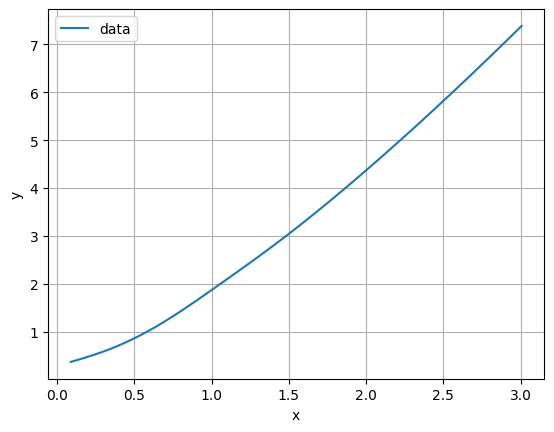

Checking constant function
Constant function is not a good fit.
Score:  -0.5716508106457115
Constant:  [1.84724563]
Generating Initial population population


100%|██████████| 10/10 [00:53<00:00,  5.38s/it]


Best score:  -199.8232862054021
Best ansatz:   params[0] + params[1] * x
Best params:  [-0.19989518  2.22521646]
Generation: 1


100%|██████████| 10/10 [00:31<00:00,  3.18s/it]


Best score:  -0.0063709584853258025
Best ansatz:   params[0] + params[1] * x + params[2] * x**2
Best params:  [0.14457718 1.34372984 0.37802438]
Generation: 2


100%|██████████| 10/10 [00:24<00:00,  2.43s/it]

Best score:  -0.0006358340696366515
Best ansatz:   params[0] + params[1] * x + params[2] * x**2 + params[3] * x**3
Best params:  [ 0.24925327  0.89784784  0.80579775 -0.10903759]
Exit condition met.


In [4]:
sym_expr = LLMSR.kan_to_symbolic(model, client, gpt_model="openai/gpt-4o", exit_condition=min(res['train_loss']).item())

In [5]:
import pickle
with open('./sym_expr_4o.pkl', 'wb') as hnd:
    pickle.dump(sym_expr, hnd)

In [6]:
import pickle
with open('./sym_expr_4o.pkl', 'rb') as hnd:
    sym_expr = pickle.load(hnd)

In [7]:
initial_params = []
for kan_conn, sub_res in sym_expr[0].items():
    if sub_res is None:
        print(f"Could not fit a function for connection {kan_conn}")
        continue
    highest_score_element = max((item for sublist in sub_res for item in sublist), key=lambda item: item['score'])
    print(f"Approximation for {kan_conn}: {highest_score_element['ansatz'].strip()}")
    print(f"Parameters are {np.round(highest_score_element['params'], 1)}")
    initial_params += list(highest_score_element['params'])

Approximation for (0, 0, 0): params[0] * np.sin(params[1] * x + params[2]) + params[3]
Parameters are [-0.1  3.1 -3.1 -0. ]
Approximation for (0, 1, 0): params[0] + params[1] * x + params[2] * x**2
Parameters are [-0.2  0.   0.1]
Approximation for (1, 0, 0): params[0] + params[1] * x + params[2] * x**2 + params[3] * x**3
Parameters are [  5.7  48.1 155.5 192.3]
Approximation for (2, 0, 0): params[0] + params[1] * x + params[2] * x**2 + params[3] * x**3
Parameters are [ 0.2  0.9  0.8 -0.1]


In [8]:
def learned_f(X, *params):
    x0, x1 = X
    l11, l12 = params[0] * np.sin(params[1] * x0 + params[2]) + params[3], params[4] * x1**2 + params[5] * x1 + params[6]
    l21 = params[7] * np.sin(params[8] * (l11+l12) + params[9]) + params[10]
    l31 = params[11] * np.exp(params[12] * l21) + params[13] * l21 + params[14]
    return l31

In [9]:
from scipy.optimize import curve_fit
initial_params = np.random.uniform(-1, 1, 15)
popt, _ = curve_fit(learned_f, (dataset['train_input'].cpu().detach().numpy()[:,0], dataset['train_input'].cpu().detach().numpy()[:,1]), dataset['train_label'].cpu().detach().numpy().flatten(), p0=initial_params, maxfev=100000)
popt

/var/folders/b6/m5qrk7z12lxb7lpygv99mnmw0000gn/T/ipykernel_14839/1459366936.py:5: RuntimeWarning: overflow encountered in exp
  l31 = params[11] * np.exp(params[12] * l21) + params[13] * l21 + params[14]


array([-23.32362201,  55.95447352,  53.29079198, -16.98973979,
       -36.82885728,  -1.38436046, -16.47997591,   0.19418254,
         3.86778638,  -3.98825936,   0.91479589,   0.08731337,
         2.26311258,  -1.22760342,   2.24614271])